## This file is based and inspired by the the following papers

> The classification method of type of days or regime is  based on [CTrSCo2013](https://ieeexplore.ieee.org/document/6466542), [SJoHCl2012](https://www.osti.gov/servlets/purl/1068417) & [BHa2020](https://www.sciencedirect.com/science/article/pii/S0960148120303803)

> The Solar Global Horizontal (GHI) Irradiance prediction equation based on fourrier expansions is from [SAyMSe2016](https://ieeexplore.ieee.org/document/7855546)

In [1]:
#Optimization Modelling#
import cvxpy as cp

# Allow to load and save python file
import pickle

#Solvers#
import mosek


#Additional packages
import pandas as pd,  numpy as np
import random
import matplotlib.pyplot as plt
from array import *
from statistics import mean
from itertools import chain
from scipy import signal, spatial
from scipy.stats import norm
import math 

#Profiling 
import time
from tqdm import tqdm

pd.options.mode.chained_assignment = None  # default='warn'

import sys, importlib
# %jupyter matplotlib
%matplotlib inline


In [2]:
# Add module folder to path if not present.
module_path = 'C:\\Users\\jprince\\Documents\\NUTSTORRE\\My_Jupiter\\GitJupLab\\SATIE_jupy\\My_modules'
if module_path not in  sys.path: sys.path.append(module_path)

import probVar, regSwitchSolarPred as rssp

### Regime or type of day 

==> Clear day (0) 

==> Overcast day (1)


==> Mild day (2)


==> Moderate day (3)


==> High day (4)



In [3]:
# nb_day_of_year = 365                   # Total number of day in a year ;; working with 2022
# nb_hours_of_day = 24                   # Total number of hour in a day ;

# doy = np.arange(1,365 + 1)              # Named 'd' in paper. Day of year (doy in [1, 365], 1: January 1 | 365: december 31
# hod = np.arange(0,nb_hours_of_day)      # Named 'T' in paper. hour of day (hod in [1,24])

# Φ = np.deg2rad(48.117266)               # Latitude (in degree) of the place i.e. Rennes 

# δ = 23.45*np.sin(np.deg2rad(360*(284+doy)/365)) # randians (365 items)
# δ = np.kron(δ,np.ones(nb_hours_of_day))          # randians (365*24 items)


# w = np.deg2rad(360*(12-hod)/24)                  # Hour angle w in paper (24 items)
# night = np.rad2deg(abs(w))>=90                   # nigth time
# w[night] = 0                                     # set nigth irradiance to zero 
# w = np.kron(np.ones(nb_day_of_year),w) # Hour angle w in paper (24 items)

# # (np.pi)/180 to convert angle in randians
# cos_θz =( np.sin(δ)*np.sin(Φ) + np.cos(δ)*np.cos(Φ)*np.cos(w) )# in randians
# # cos_θz =( np.cos(w) )# in randians

# θz = np.arccos(cos_θz)            # in randians

# AM = 1/θz                         # AM = sec(Θz)

# CSI = 1367*(0.7)**(AM**0.678)
# noon_df = pd.date_range(start='1/1/2018 12:00 ',end='12/31/2018 23:00',freq='D')
# CSI_df = pd.DataFrame(index=pd.date_range(start='1/1/2018',end='12/31/2018 23:00',freq='H'), data=CSI)

# noon_bin = [True if elm in noon_df else False for elm in CSI_df.index ]

# CSI12h = CSI_df.iloc[:,][noon_bin]

### Load data for 3 years 2018,2019,2020
> Data (Denver Location) are extracted from the [National Solar Radiation Database](https://maps.nrel.gov/nsrdb-viewer/). More information about the database is given [Here](https://www.youtube.com/watch?v=dDXkgjMZA4k)

In [4]:
# The data are extracted from 
fname = ['2018','2019','2020']
folder = '.\Solar_Prediction\yearly_data'
file_name = f'{folder}\\{fname[0]}.csv'
# THe initial data has a freq of 5mn

In [5]:
new_index = {} # Dictitonary to index dataframe

for i in range(0,3): # For each year in the dataset 
    year_last = int(fname[i])+1
    
    y1 = '01/01/'+fname[i]+' 00:00'
    y2 = '31/12/'+fname[i]+' 23:55'
    
    new_index.update({fname[i]: pd.date_range(y1,y2,freq='5T')}) # Create an index for the dataset

    
    
data = {} # Dict to save data by year 
for indx, elm in enumerate(fname):
    file_name = f'{folder}\\{fname[indx]}.csv' # Define filename
    data_file = pd.read_csv(file_name,low_memory=False)
    
#     data_file.drop(data_file.keys()[23:],axis =1,inplace=True) # get rid of collum 23 : end ( Useless in our case)
    data_file.columns = data_file.iloc[1] # Change the columns name
    
    # Extract important data for application, ie GHI :Gloal horizontal Iradiance
    data_bis = pd.DataFrame(data=data_file.iloc[2:,[7,10]])
    data_bis.index=new_index[elm]
    
    
    for elmm in data_bis.columns:
        data_bis[elmm] = np.array(data_bis[elmm], dtype=float)
        
    data.update({elm:data_bis })

### Plot  Clear sky and real_irradiance for 4 days

Text(0, 0.5, 'Irradiance(W/$m^{2}$)')

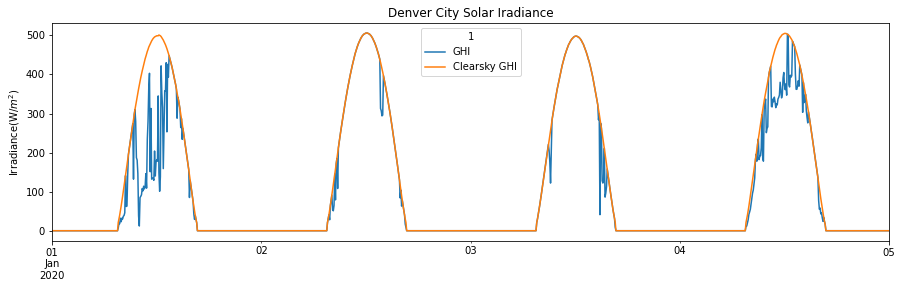

In [6]:
year = '2020'
data[year][data[year].index<=year+'-01-05'].plot(figsize=(15,4),)

plt.title('Denver City Solar Iradiance')
plt.ylabel('Irradiance(W/$m^{2}$)')

### Compute Daily Clearness Index 
### <div align="center">$ CI = \dfrac{Measured\, Solar\, Insolation}{Calculated \,Clear \,Sky \,Solar  \,Insolation}$</div>


In [7]:
# Resample data in day to compute CI
data_resample = {}
for elm in data: 
    int_var = data[elm].resample('D').mean()
    int_var['DCI']  = int_var['GHI']/int_var['Clearsky GHI'] # Add new collumn to the resampled data
    
    data_resample.update({elm: int_var})


### Plot daily CI

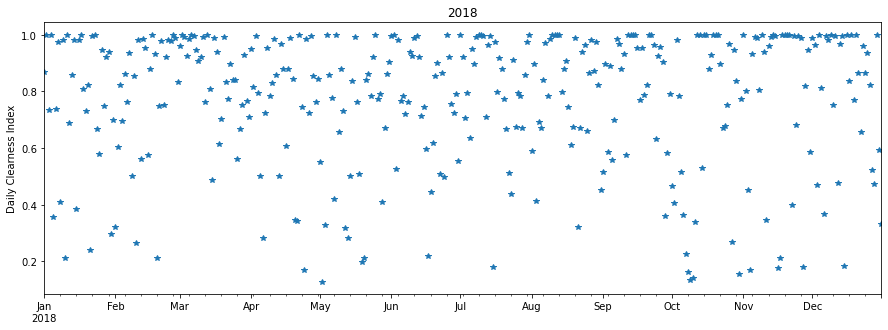

In [8]:
data_resample['2018']['DCI'].plot(figsize=(15,5), ls='None', marker='*')
plt.ylabel('Daily Clearness Index')
plt.title('2018');

### Compute Daily Variability Index 
### <div align="center">$ VI = \dfrac{\sum^{24}_{k=2} \sqrt{(GHI_k -GHI_{k-1})^2 + \Delta t^2 }}{\sum^{24}_{k=2} \sqrt{(C_sGHI_k - C_sGHI_{k-1})^2 + \Delta t^2 }}$</div>


In [9]:
for elm in data: 
#     int_var = np.sqrt(data['2018'].diff()**2 + Δt**2).resample('D').sum()
    int_var =  np.sqrt(data[elm].diff()**2).resample('D').sum()
    cur_data = data_resample[elm] # Get previous ressample df
    cur_data['DVI'] = int_var['GHI']/int_var['Clearsky GHI'] # Add new collumn to the resampled data
    data_resample[elm] = cur_data # Change replace previous df in resample dict

### Plot Daily VI

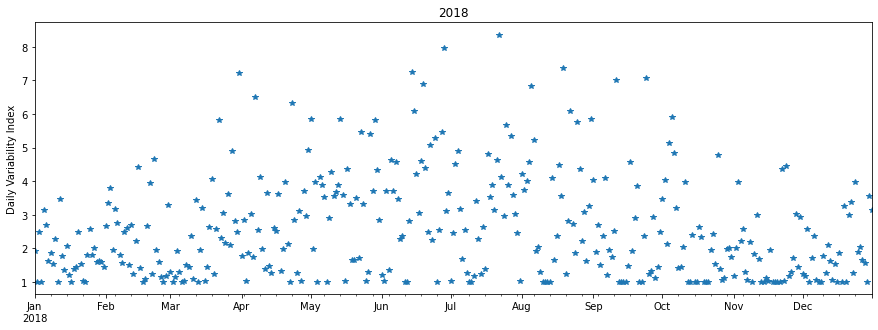

In [10]:
data_resample['2018']['DVI'].plot(figsize=(15,5), ls='None', marker='*')
plt.ylabel('Daily Variability Index')
plt.title('2018');

> ###  Type of Day classification 
>> ####  CI $\geq $ 0.5 & VI $< $ 2 ==> Clear day (0)
>> ####  CI $< $ 0.5 & VI $< $ 2 ==> Overcast day (1)
>> ####                2 $\leq $ VI $< $ 5 ==> Mild day (2)
>> ####                5 $\leq $ VI $< $ 10 ==> Moderate day(3)
>> ####                10 $\leq $ VI  ==> High day(4)





### Classify data according to the type of day

In [11]:
for year in data_resample:
    day_type_list = []
    for elm in data_resample[year].index:
        ci = data_resample[year].loc[elm]['DCI'] # Daily Clear Sky index
        vi = data_resample[year].loc[elm]['DVI'] # Daily Variability index

        if (ci >=0.5) & (vi<2):
            day_type_list.append(0)
        elif (ci <0.5) & (vi<2):
            day_type_list.append(1)
        elif (2 <= vi) & (vi<5):
            day_type_list.append(2)
        elif (5 <= vi) & (vi<10):
            day_type_list.append(3)
        else:
            day_type_list.append(4)

    # Add new collumn to df        
    cur_data = data_resample[year]
    cur_data['Day type'] = np.array(day_type_list)
    data_resample[year] = cur_data


### Plot Daytype Classification

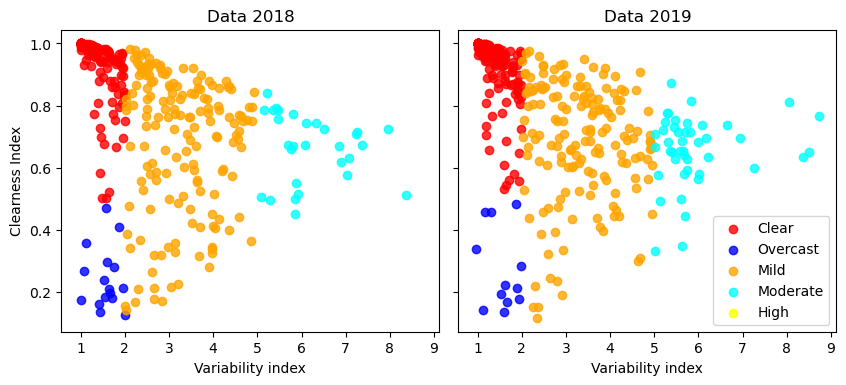

In [12]:
col = ['red','blue','orange','cyan','yellow']

years = ['2018', '2019',] # Used two years of training

fig, axx = plt.subplots(1,2, figsize=(10,4),dpi=100, sharex=True, sharey=True)

daytype={}
for year, axiss in zip(years, axx.flatten()):
    for elm in range(5):
        # Extract all the day of the type elm
        rr = data_resample[year][data_resample[year]['Day type']==elm]
        daytype.update({(year,elm):rr})
        axiss.scatter(rr.loc[year].loc[:,'DVI'], 
                    rr.loc[year].loc[:,'DCI'],color=col[elm], alpha=0.8)
        axiss.set(title = (f'Data {year}'),  xlabel='Variability index')
axx[0].set(ylabel='Clearness Index',)
        
plt.legend(['Clear','Overcast','Mild','Moderate','High'])     
plt.subplots_adjust(wspace=0.05)
plt.savefig('Class_result.pdf')

<a id="Irrad_Pred"></a>
# Solar Global Horizontal Irradiance prediction equation based on fourrier expansions
> ## $\widehat{y}(t)$ = $\beta_0 + \beta_1 CSI(t) + \sum_{i=1}^{9}\alpha_{2i} \cos(iwt)$
> ## $\;\;\;\;$       = $\beta_0 + \beta_1 CSI(t) + \alpha_{2} \cos(wt) + \alpha_{4} \cos(2wt) + \sum_{i=3}^{9}\alpha_{2i} \cos(iwt)$

###  Where $\;\; w$ = $\dfrac{2\pi}{T}$, and  T  is the number of period of total daylight in a day 

# Formulate and solve optimization problem 
#### To identify parameters $\beta_0, \beta_1, \alpha_{2}, \alpha_{4}, \alpha_{6}, \ldots \alpha_{18}  $ of Eq defined in [section](#Irrad_Pred) for each type of regime $ r \in \{0, \ldots, 3\}$ 

#### The predicted irradiance for the regime $r$ is writen as follows: 

 ## $$  \widehat{y}(t)^{r} = \beta_0^{r} + \beta_1^{r} CSI(t) + \sum_{i=1}^{9}\alpha_{2i}^{r} \cos(iwt) $$ 

In [13]:
h_start_daylight = 6 #daylight starting hour
h_end_daylight = 18 # Daylight ending hour

# Convert daylight starting and ending time in period
# ToDo : Refine the daylight period depending on the period of the year 
per_start_daylight, per_end_daylight = int(h_start_daylight*60/5) ,int(h_end_daylight*60/5) 

T = per_end_daylight - per_start_daylight # Total number of period of dailight 

# definition de a
t_list = np.arange(per_start_daylight,per_end_daylight)

# Optimization variables dict
beta_dict = {}
alpha_dict = {}
gamma_dict = {}


i_list = [1, 2, 3, 4, 5, 6, 7, 8, 9] # coefficient i in cos(iwt)

t = np.arange(0,probVar.per_day)

w = 2*np.pi/T # T must define a whole cosine period

years = ['2018','2019']
day_type = 1


for day_type in range(0,4): # For each daytype compute the coeff 
    # Only four given that there is No HIGH day Type in our dataBase(Prev figure)
    
    print(f'Current day_type:  {day_type} ********************')
    # Optimization variables
    ββ = cp.Variable(2)           # β0 and β1 in [SAyMSe2016]
    αα = cp.Variable(len(i_list)) # 
#     γγ = cp.Variable(4)

    obj_year_list = [] # List to store yearly opbjectives

    for year in years: # For each year of training data
        print(f'\t Current year: {year}')
        obj_day_list = [] # List to store daily opbjectives

        work_day = [str(elm)[:10] for elm in daytype[(year,day_type)].index] # Select daytype data of currrent year


        for day in work_day: # For each day

            int_date = pd.date_range(day,periods=2,freq='D')# Create new date range that consist of [day, day+1]
            bdries = [str(elm)[:10] for elm in int_date ] # Extract [day, day+1] in str: they are the Bondaries (bdries)

            curDay_data = (data[year][ (data[year].index >= bdries[0]) & 
                                    (data[year].index <  bdries[1]) ])
            # Predicted value over the current day
            y_pred  = (ββ[0] + ββ[1]*curDay_data['Clearsky GHI'].values[per_start_daylight:per_end_daylight] +
                        np.sum([alpha*np.cos(i*w*t_list) for i, alpha in zip(i_list,αα)],axis=0))
            # Real values of the current day
            y_real = curDay_data['GHI'].values[per_start_daylight:per_end_daylight]

            # add the daily sum square error to the obj_day_list
            obj_day_list.append(cp.sum((y_real-y_pred)**2))

        # Sum up obj_day_list to get yearly objective
        obj_year_list.append(cp.sum(obj_day_list))

    # Define the problem by minimizing the sum over each year objectives
    prob = cp.Problem( cp.Minimize(cp.sum(obj_year_list)) )

    print(f'\t\t Solving Global Problem \n')
    # Solve problem 
    prob.solve(solver=cp.GUROBI,)
    
    # Store Fourrier expansion parameters
    beta_dict.update({day_type: ββ.value })
    alpha_dict.update({day_type: αα.value })
#     gamma_dict.update({day_type: γγ.value })


Current day_type:  0 ********************
	 Current year: 2018
	 Current year: 2019
		 Solving Global Problem 

Set parameter Username
Academic license - for non-commercial use only - expires 2023-03-12
Current day_type:  1 ********************
	 Current year: 2018
	 Current year: 2019
		 Solving Global Problem 

Current day_type:  2 ********************
	 Current year: 2018
	 Current year: 2019
		 Solving Global Problem 

Current day_type:  3 ********************
	 Current year: 2018
	 Current year: 2019
		 Solving Global Problem 



# Predict daily Irradiance at a fixed Hour (10 am) 

> ###  The predicted daily irradiance is given by the predicted regime/daytype producing the lowest Mean Squared Error as follows

## $$ argmin_{r \in \{0, \ldots, 3\}}  \dfrac{\sum_{t=00am}^{10am} \big( \widehat{y}(t)^{r} - Actual Irradiance(t) \big)^{2}}{K} $$
> #### where K is the total number of periods between $00am$  and $10am$

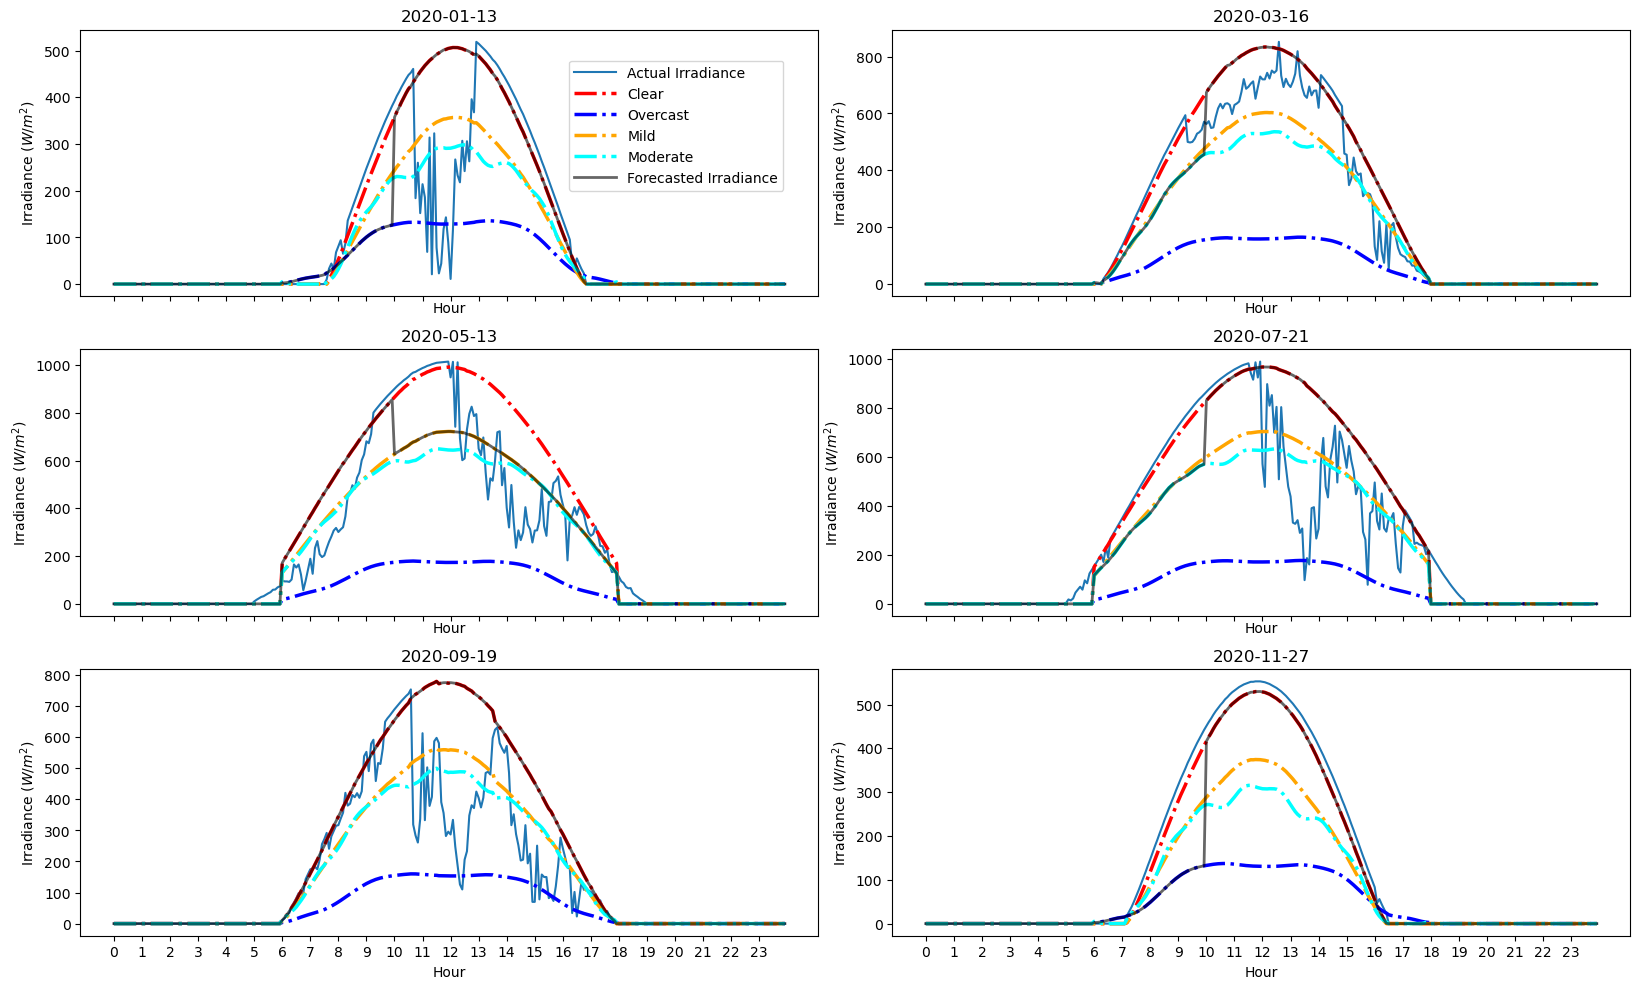

In [14]:
# definition de a
t = np.arange(0,288,)

frcst_hour = 10                      # Define Hour where forecasting occurs 
frcst_period= int(frcst_hour*288/24) # Convert the forecastion hour in period


# testing set Choose some random days and months
year = '2020'
month = ['01', '03', '05', '07', '09', '11']
day0_int = [12, 15, 12, 20, 18, 26, 5]



fig, axx = plt.subplots(3,2, figsize = (20,12), dpi=100, sharex=True,)

for indx, axiss in zip(range(6),axx.flatten()):

    day1 = year+'-'+month[indx]+'-'+str(day0_int[indx]+1)
    day2 = year+'-'+month[indx]+'-'+str(day0_int[indx]+2)

    #Extract working data 
    curDay_data = data[year][(data[year].index >= day1) & (data[year].index < day2)]
    # curDay_data2 = data[year][(data[year].index >= day0) & (data[year].index < day1)]

    # Define the previous day regime i.e. regime in which the irradiance prediction is in until the forecasted hour
    # is reached and hence the predicted regime is updated
    day_type= np.random.randint(0,4) # Previous day regime is chosen randomly
    prevDay_regimeData = (beta_dict[day_type][0] + beta_dict[day_type][1]*curDay_data['Clearsky GHI'].values +
                      np.sum([alphas*np.cos(i*w*t) for i, alphas in zip(i_list,alpha_dict[day_type])],axis=0))

    
    err_list = [] # TO store Mean squared error

    # Extract and plot real_irradiance
    real_irradiance = curDay_data['GHI'].values
    axiss.plot(real_irradiance,)

   #  for each type of regime
    for day_type in range(0,4):
        ββ = beta_dict[day_type]
        αα = alpha_dict[day_type]
#         γγ = gamma_dict[day_type]

        # compute the predicted irradiance of the current regime based on the Clearsky GHI
        y_pred =  (ββ[0] + ββ[1]*curDay_data['Clearsky GHI'].values +
              np.sum([alphas*np.cos(i*w*t) for i, alphas in zip(i_list,αα)],axis=0))

        # Compute mean square error between actual irradiance and the current predicted 
        # irradiance for the first 'frcst_hour' hours of the day and add it to the err_list
        err_list.append( ((( real_irradiance - rssp.zeroing(y_pred, per_start_daylight, per_end_daylight))[:frcst_period])**2).sum()/frcst_period )

        # plot the predicted irradiance of the current day based on the day tyoe
        axiss.plot(rssp.zeroing(y_pred, per_start_daylight, per_end_daylight), lw=2.5, ls='dashdot', color=col[day_type])
        axiss.set(xticks=range(0,284,12), xticklabels=range(0,24))

    # Get index of the element that has produced lowest MSQ
    indx = np.array(err_list).argmin()

    # Compute the forecasted irradiance based on result of lowest MSQ
    int_var = (beta_dict[indx][0] + beta_dict[indx][1]*curDay_data['Clearsky GHI'].values +
                      np.sum([alphas*np.cos(i*w*t) for i, alphas in zip(i_list,alpha_dict[indx])],axis=0))
    
    # Set the forecast for the rest of days as the one which has produced the lowest MSQ
    prevDay_regimeData[frcst_period: ] = int_var[frcst_period: ]

    # Plot the whole day predicted irradiance
    axiss.plot(rssp.zeroing(prevDay_regimeData, per_start_daylight, per_end_daylight),lw=2, color='k', alpha=0.6,)
    
    
    axiss.set(title=day1, xlabel='Hour', ylabel='Irradiance $(W/m^{2})$')

    
fig.legend(['Actual Irradiance', 'Clear', 'Overcast','Mild', 'Moderate', 'Forecasted Irradiance'],
           handlelength=3,
          bbox_to_anchor=(0, 0., 0.48, 0.86))
# # plt.legend(['Actual Irradiance', 'Previous day', 'Clear', 'Overcast','Mild', 'Moderate', 'Forecast Irradiance'],handlelength=4)
plt.subplots_adjust(wspace=0.1)

<div class="alert alert-block alert-info">
<b>Note:</b> The following cell saves the Most important variables to use in other scripts
</div>

 The variables are saved in the file `regSwitching_params.pkl` (located in the [dataFiles](../dataFiles) folder) which is a dictionnary with the following keywords:
 - ***'2020_data'*** : The Testing Set `data['2020']`
 - ***'per_daylight'*** : The daylight periods `per_daylight`
 - ***'model_params'*** : The Model parameters `model_params`

In [15]:
# # Save most important variables to use in other script
# saving_dict = {}
# saving_dict.update({'2020_data':data['2020'],
#                     'per_daylight': per_daylight,
#                     'model_params': model_params })# division to convert

# # Write into a file 
# file_name = 'regSwitching_params.pkl'
# main_folder = 'C:\\Users\\jprince\\Documents\\NUTSTORRE\\My_Jupiter\\GitJupLab\\SATIE_jupy\\'
# saving_folder_file = main_folder + 'MILP\\DataFiles\\'+ file_name


# Predict daily Irradiance at a : 
### given variable frequency (`h_frcst_freq` in hour) and using a variable length backward looking windows (`h_back_windows}` in hour)

##  The predicted daily irradiance is given by the predicted regime/daytype producing the lowest Mean Squared Error as follows

## $$ argmin_{r \in \{0, \ldots, 3\}}  \dfrac{\sum_{t=l_b}^{u_b} \big( \widehat{y}(t)^{r} - Actual Irradiance(t) \big)^{2}}{K} $$
> #### - where $u_b$ is the hour the day when the prediction occurs i.e. last hour considered in the backward looking windows
> #### - where $l_b = u_b - $ $h$_$back$\_$windows$ is the first hour considered the backward looking windows
> #### - where K is the total number of periods covered by `h_back_windows`

In [17]:
per_daylight = per_start_daylight, per_end_daylight
model_params = beta_dict, alpha_dict, i_list 

Δt = 5
# definition of the length of the backward facing windows
h_back_windows = 1                             # Number of hours can be float i.e 0.25 ==>15mn, 0.5==> 30mn
per_back_windows = int(h_back_windows*60//Δt)  # Convert hour in period

# Definition of the updating frequency
h_frcst_freq = 1                               # Number of hours can be float i.e 0.25 ==>15mn, 0.5==> 30mn
per_frcst_freq = h_frcst_freq*60//Δt           # Convert hour in period

nb_sim_days = 1# Define numbers of simulation days

daily_hor = 1440//Δt # 


year = '2020'
month = '10'
day0_int = 18

star_date = year + ' ' + month +' ' + str(day0_int) # Define initial day

# Define hours where forcasting occurs
frcst_hour_list= list(map(int,np.arange(h_start_daylight, h_end_daylight, h_frcst_freq)[1:] ))
# Convert previous hour list in period where forcasting occurs
frcst_per_list= list(map(int, np.arange(per_start_daylight, per_end_daylight, per_frcst_freq)[1:])) 

# Define total forecasting period over the number of days of simulation
tot_frcst_per_list = frcst_per_list
for elm in range(1,nb_sim_days): # Define instants where forcasting occurs for the whole sumulation
    tot_frcst_per_list = tot_frcst_per_list + list((elm)*probVar.per_day + np.array(frcst_per_list))
    

# Define the size of the predicted GHI over the number of day of simulation (+1 due to Maximum 24H MPC horizon)
pred_GHI = np.zeros(((nb_sim_days+1)*probVar.per_day))

# Define the number of period of simulation.
real_GHI = np.zeros((nb_sim_days*probVar.per_day))


DAYS = pd.date_range(start=star_date, periods=nb_sim_days, freq='D')



for day_index, cur_day in enumerate(DAYS):

    #Define days 
    day_prev = cur_day - cur_day.freq
    day_init = cur_day
    day_future = cur_day + cur_day.freq

    #Extract previous and Current day real data 
    prevDay_data =  data[year][(data[year].index >= day_prev) & (data[year].index < day_init)]
    curDay_data = data[year][(data[year].index >= day_init) & (data[year].index < day_future)]

    # Define predicted values dependant on the type of regime for all daytype
    curDay_data_dict = rssp.dayType_dataPred((model_params), (per_daylight), 
                                             curDay_data )

    # Initializing 
    if day_index == 0: # If the day of starting simulation, 
        # Previous day regime
        day_type = 1 # Initialize current day type
        pred_GHI = rssp.initialize_predGHI(model_params, per_daylight, 
                                            prevDay_data, pred_GHI, day_type )

    d0_index = day_index*daily_hor       # lower bound current day
    d1_index = (day_index+1)*daily_hor   # Upper bound currend day
    
    # for each instant of the current day predict the Irradiance: 
    # d1_index is the end of the day index. Choose a certain other instant in frcst_per_list 
    # to see the prediction from that instant into the future i.e. commented line bellow
    for k in range (d0_index, d1_index): 
#     for k in range (d0_index, frcst_per_list[2]+1): 
        
        upd_cur_k = k - d0_index # # Updated current k so that the updated cur_k is always in [0, 288], Δt = 5 mn
        pred_GHI, day_type  = rssp.pred_Irradiance_updater(k, d0_index, tot_frcst_per_list, per_back_windows, pred_GHI, 
                                            (per_start_daylight, per_end_daylight), 
                                            (curDay_data, curDay_data_dict), 
                                            day_type ) 

    real_GHI[d0_index:d1_index] = curDay_data['GHI'].values

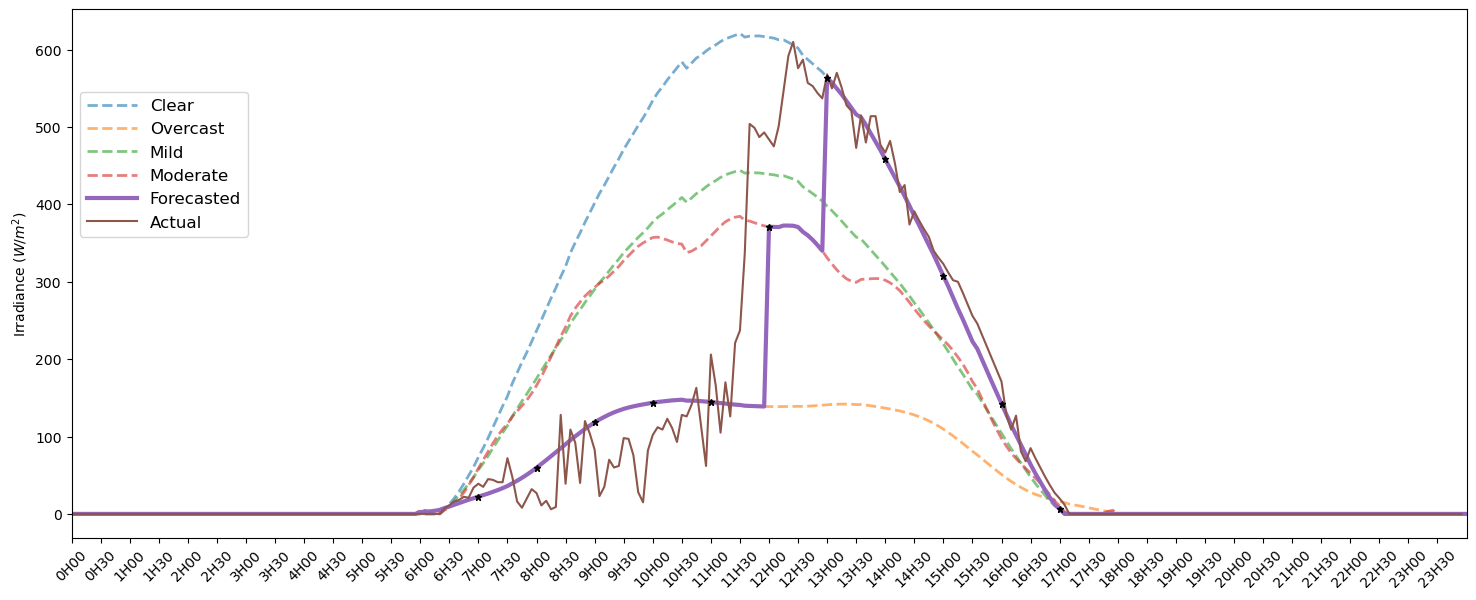

In [18]:
pred_GHI2 = np.zeros(((nb_sim_days+1)*probVar.per_day))

plt.figure(figsize=(18,7), dpi=100)

for elm in range(4): # Plot all the type of day forecast
    rssp.initialize_predGHI((beta_dict, alpha_dict, i_list), (per_start_daylight, per_end_daylight), 
                                            curDay_data, pred_GHI2, elm ); # Initialize the type of day prediction 
    plt.plot(pred_GHI2, ls='--', lw=2, alpha=0.6)

plt.plot(pred_GHI,lw=3 ) # Predicted Irradiance /150 in power
plt.plot(real_GHI, )     # Predicted Irradiance /150 in power


plt.xlim((0,288))
plt.ylabel('Irradiance $(W/m^{2})$')
plt.plot(frcst_per_list, pred_GHI[frcst_per_list], 'k*', markersize=5 )
plt.legend(['Clear', 'Overcast','Mild', 'Moderate', 'Forecasted', 'Actual', ],
           handlelength=3,
          bbox_to_anchor=(0, 0., 0.48, 0.86),fontsize=12 )

labbel = np.array([(f'{elm}H00', f'{elm}H30')  for elm in range(0,24)]).reshape(-1)
plt.xticks(range(0,daily_hor,6), labels=labbel, rotation=45);

if (k)in frcst_per_list: # Plot bakward looking windows only if the instant k is a 
    plt.axvline(k, color='red', lw=0.5)
    plt.axvspan(k-per_back_windows,k, color='red', alpha=0.2)